### 📚 사용 라이브러리

In [142]:
# 데이터 분석 기초
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 포트 지정 및 마이너스 부호 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  

# 모델 구축
from sklearn.pipeline import make_pipeline

# 데이터 전처리
from sklearn.model_selection import train_test_split, validation_curve, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

# 훈련 모델
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 성능 평가
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

# 불균형 데이터셋 전처리
from imblearn.over_sampling import SMOTE

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

### 🎁 기본 데이터셋 준비

In [143]:
# 데이터 불러오기
network_log = pd.read_csv('network_log.csv')
network_log

,IP_INFO,STATUS_CONF,COUNTRY,PL_NAME
0,195.54.160.149,validated,RU,OOO Network of data-centers Selectel
1,45.155.205.233,validated,RU,OOO Network of data-centers Selectel
2,167.71.13.196,validated,NL,DIGITALOCEAN-ASN
3,45.146.164.160,validated,RU,OOO Network of data-centers Selectel
4,34.65.121.142,validated,CH,GOOGLE-CLOUD-PLATFORM
...,...,...,...,...
2106,45.83.67.153,benign,DE,Alpha Strike Labs GmbH
2107,45.83.67.188,benign,DE,Alpha Strike Labs GmbH
2108,45.83.67.224,benign,DE,Alpha Strike Labs GmbH
2109,45.83.67.45,benign,DE,Alpha Strike Labs GmbH


In [144]:
# 데이터 한글화 진행
network_log.rename(columns={
    'IP_INFO':'아이피주소',
    'STATUS_CONF':'정상/비정상',
    'COUNTRY':'접속국가',
    'PL_NAME':'접속상대'
}, inplace=True)
# 데이터 재배열
network_log = network_log[['아이피주소', '접속국가', '접속상대', '정상/비정상']]
network_log.head()

,아이피주소,접속국가,접속상대,정상/비정상
0,195.54.160.149,RU,OOO Network of data-centers Selectel,validated
1,45.155.205.233,RU,OOO Network of data-centers Selectel,validated
2,167.71.13.196,NL,DIGITALOCEAN-ASN,validated
3,45.146.164.160,RU,OOO Network of data-centers Selectel,validated
4,34.65.121.142,CH,GOOGLE-CLOUD-PLATFORM,validated


In [145]:
# 데이터의 라벨화
network_log['정상/비정상'] = network_log['정상/비정상'].map({'validated':1, 'benign':1,
                                                       'not_enough_data':0, 'pending':0})
network_log.sample(n=5)

,아이피주소,접속국가,접속상대,정상/비정상
809,139.59.176.146,GB,DIGITALOCEAN-ASN,0
241,51.210.135.55,FR,OVH SAS,0
1922,45.83.66.212,DE,Alpha Strike Labs GmbH,1
827,147.182.202.30,US,DIGITALOCEAN-ASN,0
618,163.172.209.165,NL,Online S.a.s.,0


### 🩻 데이터 시각화

In [146]:
# 결측치 확인
network_log.isnull().sum()
# 결측치가 접속자에 하나 있으므로 해당 행 drop
network_log.dropna(inplace=True)
# 다시 결측치 확인
network_log.isnull().sum()

아이피주소     0
접속국가      0
접속상대      0
정상/비정상    0
dtype: int64

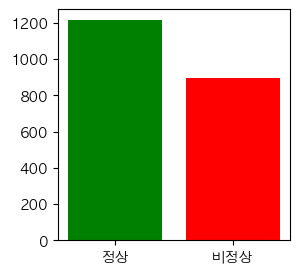

In [147]:
# 정상/비정상 비율 그래프화
plt.figure(figsize=(3, 3))
plt.bar('정상', network_log['정상/비정상'].value_counts()[1], color='green')
plt.bar('비정상', network_log['정상/비정상'].value_counts()[0], color='red')
plt.show()

In [148]:
# 가장 먼저 어떤 접속자가 많은 접속을 시도하는지를 살펴보겠습니다.
self_best_access = network_log.groupby(['접속상대', '정상/비정상'], as_index=False)['아이피주소'].count().sort_values(by='아이피주소', 
                                                                                                              ascending=False)
self_best_access.rename(columns={'아이피주소':'접속횟수'}, inplace=True)
print(self_best_access)

                              접속상대  정상/비정상  접속횟수
16          Alpha Strike Labs GmbH       1  1022
65                DIGITALOCEAN-ASN       0   298
156                    Linode, LLC       0   100
193                        OVH SAS       0    36
66                DIGITALOCEAN-ASN       1    35
..                             ...     ...   ...
125                       IONOS SE       1     1
126                  IP Volume inc       0     1
127  IP-Converge Data Center, Inc.       1     1
129                  IT House, Ltd       0     1
297                      xTom GmbH       0     1

[298 rows x 3 columns]


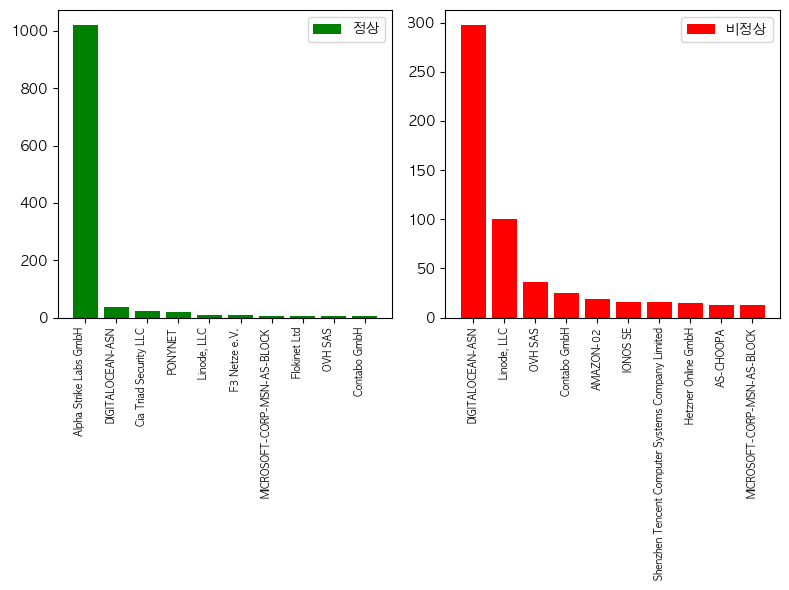

In [149]:
# 각 접속 횟수를 바탕으로 정상/비정상일때의 합성 그래프 도식화
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
# 정상 데이터
axes[0].bar(self_best_access[self_best_access['정상/비정상']==1]['접속상대'].head(10), 
         self_best_access[self_best_access['정상/비정상']==1]['접속횟수'].head(10), label='정상', color='green')
axes[0].legend()
axes[0].set_xticklabels(self_best_access[self_best_access['정상/비정상']==1]['접속상대'].head(10).unique(), 
                        rotation=90, ha='right', fontsize=7)
# 비정상 데이터
axes[1].bar(self_best_access[self_best_access['정상/비정상']==0]['접속상대'].head(10), 
         self_best_access[self_best_access['정상/비정상']==0]['접속횟수'].head(10), label='비정상',  color='red')
axes[1].set_xticklabels(self_best_access[self_best_access['정상/비정상']==0]['접속상대'].head(10).unique(), 
                        rotation=90, fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()

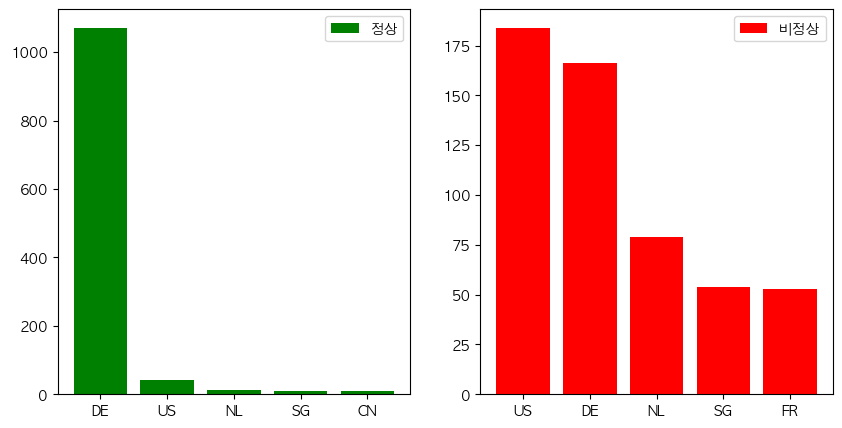

In [150]:
# 어떤 국가에 따른 정상/비정상 데이터 분포
new_access = network_log.groupby(['접속국가', '정상/비정상'], as_index=False)['아이피주소'].count()
best_guy = new_access.loc[new_access['정상/비정상']==0].sort_values(by='아이피주소', ascending=False).head()
worst_guy = new_access.loc[new_access['정상/비정상']==1].sort_values(by='아이피주소', ascending=False).head()
# 비정상 데이터
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].bar(best_guy['접속국가'], best_guy['아이피주소'], color='red', label='비정상')
axes[1].legend()
# 정상 데이터
axes[0].bar(worst_guy['접속국가'], worst_guy['아이피주소'], color='green', label='정상')
axes[0].legend()
plt.show()

### 📟 데이터 전처리

In [151]:
# 클래스 아이피 추출하기
extract_class = lambda i: i.split('.')[0]
network_log['클래스 아이피'] = network_log['아이피주소'].apply(extract_class)
network_log.head()

,아이피주소,접속국가,접속상대,정상/비정상,클래스 아이피
0,195.54.160.149,RU,OOO Network of data-centers Selectel,1,195
1,45.155.205.233,RU,OOO Network of data-centers Selectel,1,45
2,167.71.13.196,NL,DIGITALOCEAN-ASN,1,167
3,45.146.164.160,RU,OOO Network of data-centers Selectel,1,45
4,34.65.121.142,CH,GOOGLE-CLOUD-PLATFORM,1,34


In [152]:
# 클래스 아이피에 따른 클래스를 분류
def distribute_class(df):
    if df>=0 and df<127:
        return 'A'
    elif df>127 and df<192:
        return 'B'
    elif df>=102 and df<224:
        return 'C'
    else:
        return 'ELSE'
# IPv6 제거 및 분류 적용
network_log['클래스 아이피'] = network_log['클래스 아이피'].astype(str)
network_log = network_log.loc[network_log['클래스 아이피'].str.isdigit()]
network_log['클래스 아이피'] = network_log['클래스 아이피'].astype('int')
network_log['클래스'] = network_log['클래스 아이피'].apply(distribute_class)
network_log.head()

,아이피주소,접속국가,접속상대,정상/비정상,클래스 아이피,클래스
0,195.54.160.149,RU,OOO Network of data-centers Selectel,1,195,C
1,45.155.205.233,RU,OOO Network of data-centers Selectel,1,45,A
2,167.71.13.196,NL,DIGITALOCEAN-ASN,1,167,B
3,45.146.164.160,RU,OOO Network of data-centers Selectel,1,45,A
4,34.65.121.142,CH,GOOGLE-CLOUD-PLATFORM,1,34,A


In [153]:
# 기존 아이피트주소를 라우터 주소로 변경
extract_again = lambda x: x.split('.')[0:3]
network_log['라우터 주소'] = network_log['아이피주소'].apply(extract_again).str.join('.')+'.1'
network_log = network_log[['라우터 주소', '클래스', '접속국가', '접속상대', '정상/비정상']]
print(network_log['라우터 주소'].value_counts())

라우터 주소
45.83.66.1       256
45.83.65.1       256
45.83.67.1       255
45.83.64.1       255
185.220.101.1     26
                ... 
188.166.102.1      1
188.166.45.1       1
188.166.86.1       1
193.233.81.1       1
139.59.101.1       1
Name: count, Length: 892, dtype: int64


In [154]:
# 먼저 고유한 '라우터 주소'의 개수가 1이 아닌 값을 찾습니다
unique_routers = network_log['라우터 주소'].value_counts()[network_log['라우터 주소'].value_counts() != 1].index
# 그 다음 이 값들을 사용하여 원래 DataFrame을 필터링합니다
network_log = network_log[network_log['라우터 주소'].isin(unique_routers)]
# 결과 출력
network_log.reset_index(inplace=True, drop=True)
network_log.head()

,라우터 주소,클래스,접속국가,접속상대,정상/비정상
0,157.245.108.1,B,IN,DIGITALOCEAN-ASN,1
1,194.195.246.1,C,DE,"Linode, LLC",1
2,194.195.244.1,C,DE,"Linode, LLC",1
3,194.195.244.1,C,DE,"Linode, LLC",1
4,194.233.164.1,C,DE,"Linode, LLC",1


In [155]:
# 정상/비정상 데이터의 최종 분포
network_log['정상/비정상'].value_counts()

정상/비정상
1    1089
0     199
Name: count, dtype: int64

In [156]:
# 문자열 데이터는 OrdinalEncoder로 전처리 시키겠습니다.
trans = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), ['라우터 주소', '클래스', '접속국가', '접속상대'])
    ]
)
# 그리고 원본 데이터에서 훈련 데이터와 테스트 데이터를 구분하겠습니다.
data, target = network_log.drop(columns='정상/비정상'), network_log['정상/비정상']

In [157]:
# 기존 데이터를 trans에 적용시키고
trans_data = trans.fit_transform(data)
# 특성들도 표준화 시켰으니 이번에는 각 특성에 따른 정상/비정상 데이터의 상관관계를 살펴볼까요?
corr = np.corrcoef(trans_data[:, 0], target)
print('라우터 주소와 정상/비정상 열의 상관관계 :', np.round(corr[0][1], 2))
corr = np.corrcoef(trans_data[:, 1], target)
print('접속국가와 정상/비정상 열의 상관관계 :', np.round(corr[0][1], 2))
corr = np.corrcoef(trans_data[:, 2], target)
print('접속자와 정상/비정상 열의 상관관계 :', np.round(corr[0][1], 2))
corr = np.corrcoef(trans_data[:, 3], target)
print('접속빈도와 정상/비정상 열의 상관관계 :', np.round(corr[0][1], 2))

라우터 주소와 정상/비정상 열의 상관관계 : 0.73
접속국가와 정상/비정상 열의 상관관계 : -0.74
접속자와 정상/비정상 열의 상관관계 : -0.45
접속빈도와 정상/비정상 열의 상관관계 : -0.76


<Axes: >

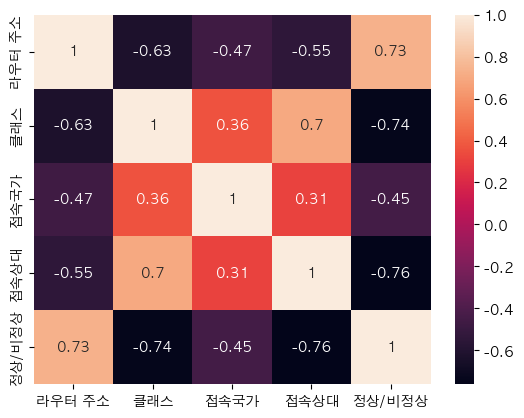

In [158]:
# 라벨링 된 데이터를 히트맵으로 그려보죠
trans_data = pd.DataFrame(trans_data,
                          columns=['라우터 주소', '클래스', '접속국가', '접속상대'])
corr_matrix = pd.concat(objs=[trans_data, network_log['정상/비정상']], axis=1).corr()
sns.heatmap(corr_matrix, annot=True)

## 🍎 모델 훈련

In [159]:
# 모델에 학습시키기 이전에 훈련세트와 테스트 세트에 대해서 나누어봅시다.
train_input, test_input, train_target, test_target = train_test_split(data,
                                                                      target,
                                                                      random_state=42,
                                                                      test_size=0.2,
                                                                      stratify=data['라우터 주소'])

In [160]:
# 이제 가장 먼저 로지스틱회귀로 해당 데이터를 훈련시켜보겠습니다.
lr = LogisticRegression()
pipeline = make_pipeline(trans,
                         lr)
pipeline.fit(train_input, train_target)
print('훈련 세트에 대한 Logistic회귀의 점수는 :', round(pipeline.score(train_input, train_target), 4))
print('테스트 세트에 대한 Logistic회귀의 점수는 :', round(pipeline.score(test_input, test_target), 4))

훈련 세트에 대한 Logistic회귀의 점수는 : 0.965
테스트 세트에 대한 Logistic회귀의 점수는 : 0.969


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

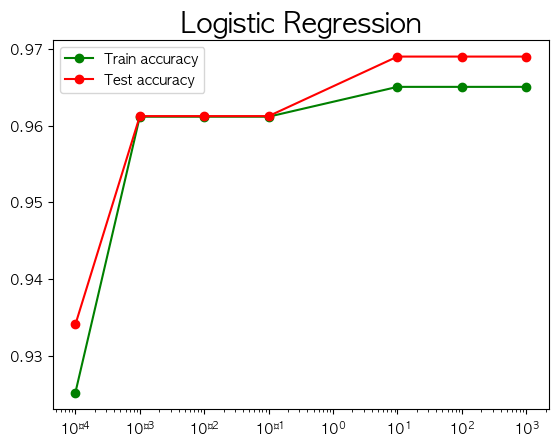

In [161]:
# C의 값에 변화에 따라 해당 모델이 어떻게 변화하는지 알아보죠
param_range = [0.0001, 0.001, 0.01, 0.1, 10, 100, 1000]
total_train, total_test = [], []
for i in param_range:
    lr = LogisticRegression(C=i)
    pipeline = make_pipeline(trans, lr)
    pipeline.fit(train_input, train_target)
    train_score = pipeline.score(train_input, train_target)
    total_train.append(train_score)
    test_score = pipeline.score(test_input, test_target)
    total_test.append(test_score)
plt.plot(param_range, total_train,
         marker='o', color='green', label='Train accuracy')
plt.plot(param_range, total_test,
         marker='o', color='red', label='Test accuracy')
plt.xscale('log')
plt.legend()
np.nan_to_num(train_score).sum()
plt.title('Logistic Regression', fontsize=20)
plt.show()

In [162]:
# 정밀도/재형ㄴ늉ㄹ/F1 Score를 구해보죠
lr = LogisticRegression()
pipeline = make_pipeline(trans,
                         lr)
pipeline.fit(train_input, train_target)
train_pred = pipeline.predict(train_input)
test_pred = pipeline.predict(test_input)
print('정밀도 :', round(precision_score(train_pred, train_target), 4))
print('재현율 :', round(recall_score(train_pred, train_target), 4))
print('f1 score :', round(f1_score(train_pred, train_target), 4))

정밀도 : 0.9724
재현율 : 0.986
f1 score : 0.9792


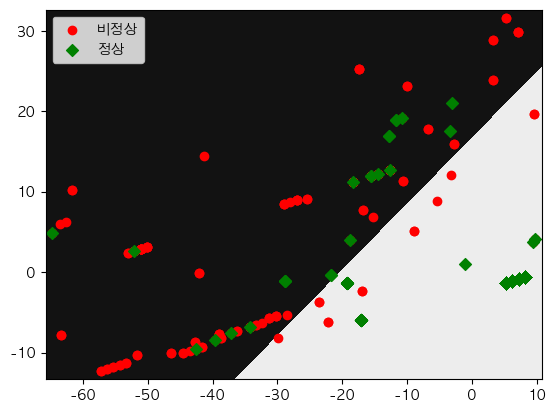

In [163]:
# 가장 먼저 훈련/테스트 세트를 정규화 시키고요!
trans_train = trans.fit_transform(train_input)
trans_test = trans.transform(test_input)

# pca를 적용시켜 차원 축소를 진행합니다.
pca = PCA(n_components=2)
pca_train = pca.fit_transform(trans_train)
pca_test = pca.transform(trans_test)

# 결정계수를 구해서 그래프를 직접 그려보고, 얼마나 잘 예측했는지를 알아볼게요!
x_min, x_max = pca_train[:, 0].min()-1, pca_train[:, 0].max()+1
y_min, y_max = pca_train[:, 1].min()-1, pca_train[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                     np.arange(y_min, y_max, 0.01))
lr.fit(pca_train, train_target)
z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# 그래프 그리기
plt.contourf(xx, yy, z, cmap='binary_r')
plt.scatter(pca_train[train_target==0, 0], pca_train[train_target==0, 1], label='비정상', marker='o', color='red')
plt.scatter(pca_train[train_target==1, 0], pca_train[train_target==1, 1], label='정상', marker='D', color='green')
plt.legend()
plt.show()

In [164]:
# SVC도 비슷할 것 같은데 그래도 한번 살펴보죠
svc = SVC()
pipeline = make_pipeline(trans,
                         svc)
pipeline.fit(train_input, train_target)
print('SVC 훈련 점수는 :', pipeline.score(train_input, train_target))
print('SVC 테스트 점수는 :', pipeline.score(test_input, test_target))

SVC 훈련 점수는 : 0.962135922330097
SVC 테스트 점수는 : 0.9612403100775194


xgboost 훈련 점수 : 0.9825242718446602
xgboost 테스트 점수 : 0.9844961240310077
      특성값    중요도
0  라우터 주소  0.168
1     클래스  0.050
2    접속국가  0.036
3    접속상대  0.745


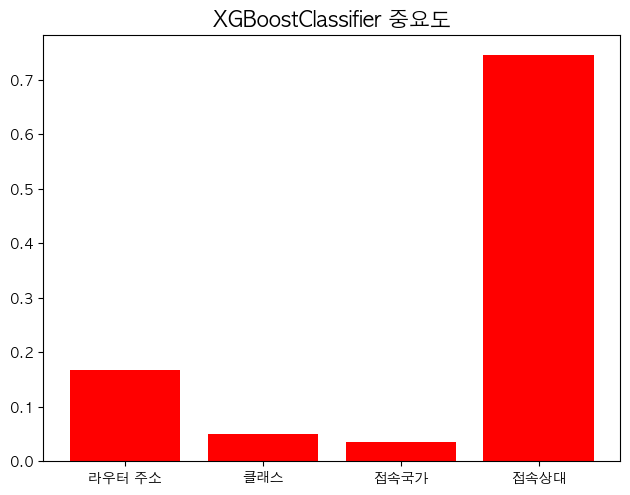

In [165]:
# 이번엔 XGBoost 모델을 볼까요?
xgbc = XGBClassifier(
    n_estimators=100,    # 생성할 트리의 개수
    learning_rate=0.1,   # 학습률
    max_depth=3,         # 트리의 최대 깊이
    subsample=0.8,       # 데이터 샘플링 비율
    colsample_bytree=0.8 # 특성 샘플링 비율
)
pipeline = make_pipeline(trans,
                         xgbc)
pipeline.fit(train_input, train_target)
print('xgboost 훈련 점수 :', pipeline.score(train_input, train_target))
print('xgboost 테스트 점수 :', pipeline.score(test_input, test_target))

# 특성의 중요도값을 한번 살펴보죠
print(pd.DataFrame({
    '특성값':['라우터 주소', '클래스', '접속국가', '접속상대'],
    '중요도':np.round(pipeline[-1].feature_importances_, 3)             
}))
plt.bar(['라우터 주소', '클래스', '접속국가', '접속상대'],
        np.round(pipeline[-1].feature_importances_, 3), color='red')
plt.tight_layout()
plt.title('XGBoostClassifier 중요도', fontsize=15)
plt.show()

In [166]:
# 이번에도 정밀도/재현율/F1 Score를 확인해보죠
pipeline = make_pipeline(trans,
                         xgbc)
pipeline.fit(train_input, train_target)
train_pred = pipeline.predict(train_input)
test_pred = pipeline.predict(test_input)
print('정밀도 :', round(precision_score(train_pred, train_target), 4))
print('재현율 :', round(recall_score(train_pred, train_target), 4))
print('f1 score :', round(f1_score(train_pred, train_target), 4))

정밀도 : 0.9851
재현율 : 0.9942
f1 score : 0.9896


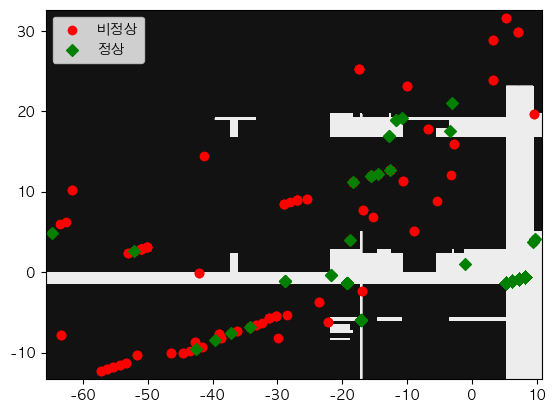

In [167]:
# 가장 먼저 훈련/테스트 세트를 정규화 시키고요!
train_scaled = trans.fit_transform(train_input)
test_scaled = trans.transform(test_input)

# pca를 적용시켜 차원 축소를 진행합니다.
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# 결정계수를 구해서 그래프를 직접 그려보고, 얼마나 잘 예측했는지를 알아볼게요!
x_min, x_max = train_pca[:, 0].min()-1, train_pca[:, 0].max()+1
y_min, y_max = train_pca[:, 1].min()-1, train_pca[:, 1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), 
                     np.arange(y_min, y_max, 0.01))
xgbc.fit(train_pca, train_target)
z = xgbc.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# 그래프 그리기
plt.contourf(xx, yy, z, cmap='binary_r')
plt.scatter(train_pca[train_target==0, 0], train_pca[train_target==0, 1], label='비정상', marker='o', color='red')
plt.scatter(train_pca[train_target==1, 0], train_pca[train_target==1, 1], label='정상', marker='D', color='green')
plt.legend()
plt.show()

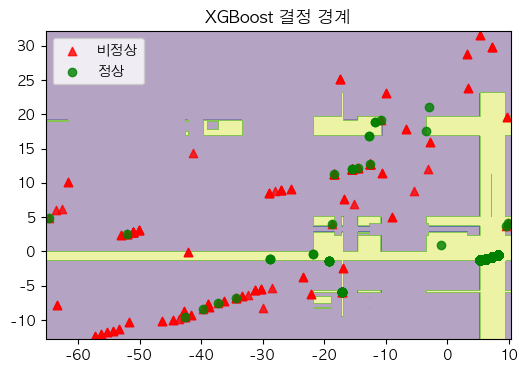

In [168]:
# 파라미터를 조금 바꿔서 진행해보죠
xgbc = XGBClassifier(
    n_estimators=200,    # 트리 개수 증가
    learning_rate=0.05,  # 학습률 감소
    max_depth=5,         # 트리 깊이 증가
    subsample=0.9,       # 데이터 샘플링 비율 증가
    colsample_bytree=0.9 # 특성 샘플링 비율 증가
)
# 가장 먼저 훈련/테스트 세트를 정규화 시키고요!
train_scaled = trans.fit_transform(train_input)
test_scaled = trans.transform(test_input)

# pca를 적용시켜 차원 축소를 진행합니다.
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# 결정 경계 그리기
x_min, x_max = train_pca[:, 0].min() - 0.5, train_pca[:, 0].max() + 0.5
y_min, y_max = train_pca[:, 1].min() - 0.5, train_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
xgbc.fit(train_pca, train_target)
# 더 조밀한 그리드로 결정 경계 계산
Z = xgbc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 결정 경계 시각화
plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(train_pca[train_target==0, 0], train_pca[train_target==0, 1], 
           c='red', marker='^', label='비정상', alpha=0.8)
plt.scatter(train_pca[train_target==1, 0], train_pca[train_target==1, 1], 
           c='green', marker='o', label='정상', alpha=0.8)
plt.legend()
plt.title('XGBoost 결정 경계')
plt.show()

ROC-AUC Score: 0.9956422018348624


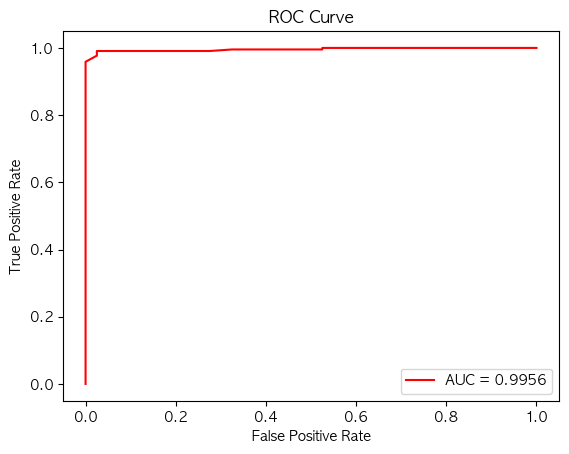

In [169]:
# 전반적인 성능 평가를 위해 ROC 커브를 그려볼게요.
transform_train = trans.fit_transform(train_input)
transform_test = trans.transform(test_input)
test_pca = pca.transform(transform_test)
xgbc = XGBClassifier()
xgbc.fit(train_pca, train_target)
y_proba = xgbc.predict_proba(test_pca)[:, 1] # 예측 확률
auc_score = roc_auc_score(test_target, y_proba)
print("ROC-AUC Score:", auc_score)
fpr, tpr, _ = roc_curve(test_target, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='red')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

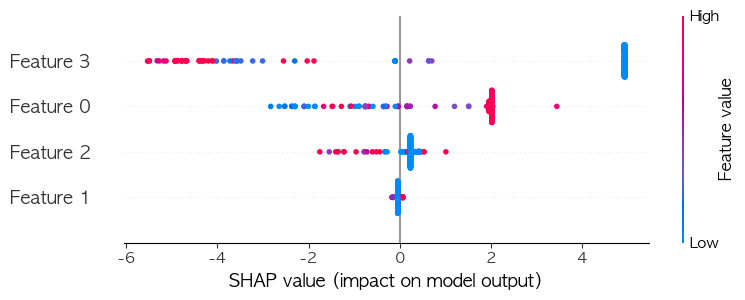

In [170]:
# Shap도 그려볼게요
xgbc.fit(transform_train, train_target)
explainer = shap.TreeExplainer(xgbc)  # xgb_model은 학습된 XGBoost 모델
shap_values = explainer.shap_values(transform_test)  # X_test는 테스트 데이터

# 전체 특성의 중요도를 요약
shap.summary_plot(shap_values, transform_test)

# 특정 샘플의 예측을 해석
shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame(transform_test).iloc[0])

## 🍇 불균형 데이터 한계 극복

In [171]:
# 불균형 데이터를 다루기 위해 SMOTE를 사용해보겠습니다.
sm = SMOTE()
trans_train, train_target = trans.fit_transform(train_input), train_target
trans_test, test_target = trans.transform(test_input), test_target
train_resampled, train_target = sm.fit_resample(trans_train, list(train_target))

pipeline = make_pipeline(xgbc)
pipeline.fit(train_resampled, train_target)
print('SMOTE가 적용된 XGBOOST 훈련 점수 :', pipeline.score(train_resampled, train_target))
print('SMOTE가 적용된 XGBOOST 테스트 점수 :', pipeline.score(trans_test, test_target))

SMOTE가 적용된 XGBOOST 훈련 점수 : 0.9885189437428243
SMOTE가 적용된 XGBOOST 테스트 점수 : 0.9844961240310077


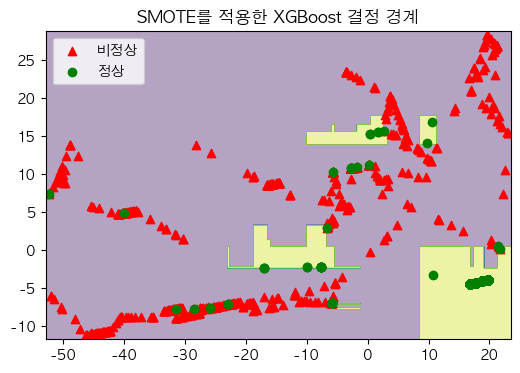

In [173]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_resampled)
test_pca = pca.transform(trans_test)

# 결정 경계 그리기
x_min, x_max = train_pca[:, 0].min() - 0.5, train_pca[:, 0].max() + 0.5
y_min, y_max = train_pca[:, 1].min() - 0.5, train_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
xgbc.fit(train_pca, train_target)
# 더 조밀한 그리드로 결정 경계 계산
Z = xgbc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 결정 경계 시각화
plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(train_pca[np.array(train_target)==0, 0], train_pca[np.array(train_target)==0, 1], 
           c='red', marker='^', label='비정상')
plt.scatter(train_pca[np.array(train_target)==1, 0], train_pca[np.array(train_target)==1, 1], 
           c='green', marker='o', label='정상')
plt.legend()
plt.title('SMOTE를 적용한 XGBoost 결정 경계')
plt.show()

In [176]:
train_pred = pipeline.predict(train_pca)
test_pred = pipeline.predict(test_pca)
print('정밀도 :', round(precision_score(train_pred, train_target), 4))
print('재현율 :', round(recall_score(train_pred, train_target), 4))
print('f1 score :', round(f1_score(train_pred, train_target), 4))

정밀도 : 0.9839
재현율 : 0.993
f1 score : 0.9885


## 🥕 모델 저장!

In [189]:
from joblib import dump

# 파이프라인 저장
dump(pipeline, 'LOG_CLASSIFIER.pkl')
loaded_model = joblib.load('LOG_CLASSIFIER.pkl')